In [1]:
# load libraries
# %pip install mlxtend

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pickle
%matplotlib inline
start_time = dt.datetime.now()

In [26]:
# set some parameters
num_files = 8
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

In [38]:
# dftest = pd.read_pickle("vars_count_entities_1_c")

In [4]:
# l1 = list(range(0,500)) + [1501]

In [37]:
# df3 =dftest.iloc[:,500:]

In [17]:
# dftest = dftest.loc[:,~dftest.columns.duplicated()]

In [19]:
# dftest.to_pickle('vars_count_entities_1_c')

In [20]:
# del df3

In [39]:
# df3.to_pickle("vars_count_entities_3_b") #add fraud label
# del df3

In [1]:
# del df1

In [3]:
# df1 = pd.read_pickle('vars_count_entities_3_b')

In [39]:
# df1.head()

In [11]:
# del df1

In [8]:
# df1 = pd.concat([df1,record_label],axis = 1)

In [43]:
# df1 = df1.merge(record_label, on = 'record', how = 'left')

In [40]:
# df1.head()

In [10]:
# df1.to_pickle('vars_count_entities_3_b')

In [31]:
# l1 = list(dftest.columns[0:500])
# if 'fraud_label' not in l1:
#     l1.append('fraud_label')
# l2 = list(dftest.columns[500:1000]) #dob_unique_count_for_ssn_homephone_1'
# l2.append('record')
# if 'fraud_label' not in l2:
#     l2.append('fraud_label')
# l2
# l3 = list(dftest.columns[1000:]) #dob_unique_count_for_ssn_homephone_1'
# l3.append('record')
# if 'fraud_label' not in l3:
#     l3.append('fraud_label')
# l3

In [5]:
# set(l1).intersection(set(l2))
# set(l2).intersection(set(l3))
# set(l1).intersection(set(l3))

{'fraud_label', 'record'}

In [6]:
# len(set(l1))+len(set(l2))+len(set(l3))

1506

In [41]:
# l2

In [42]:
# dftest.columns

In [23]:
# # dftest1 = dftest.loc[:,l1]
# del dftest
# dftest1.to_pickle("vars_count_entities_1_a")
# # dftest.filter(l2).to_pickle("vars_count_entities_1_b")
# # dftest.filter(l3).to_pickle("vars_count_entities_1_c")

In [7]:
# data = pd.read_csv('applications data.csv')
# record_label = data.filter(['record'])
# del data

In [16]:
# dftest = dftest.merge(record_label, how = 'left',on = 'record')

In [4]:
fileNames = ['vars_age_entities','vars_velocity_days_since_relative_velocity'] #'vars_count_entities_1_a','vars_count_entities_1_b','vars_count_entities_1_c','vars_count_entities_2','vars_count_entities_3_a','vars_count_entities_3_b',

In [3]:
fileNames = ['ssn_variables.csv','address_variables.csv','homephone_variables.csv','dob_variables.csv','zip_variables.csv','name_variables.csv']

In [43]:
# dftest.head()

In [18]:
# dftest.to_pickle('vars_count_entities_3')

In [19]:
# del dftest

## Run a filter on all the files

In [5]:
# i changed the following code a little bit. I think the bug with balance !=0 for num_files>1 is that the goods_keep indicates the index and not the record. 
#So I changed the index of the dataframe in the beginning itself after reading from pickle/csv
# also i removed some redundant stuff for creating filter score when i = 0 and i > 0
# I feel my laptop is not the best to run code like this hence it took a lot of time apart from the fact that my chunk size was 500-600 variables per file.

In [24]:
df = pd.read_csv(file_name)

In [25]:
df.shape

(1000000, 190)

In [27]:
%%time
num_filter = 50
filter_score_df_list = []
for i,file_name in enumerate(fileNames):
#     file_name = "vars"+str(i+1)+'.csv'
    print("*******************",file_name,"***********************")
    df = pd.read_csv(file_name)
    """
    Setting the index before
    """
    df = df.set_index(index_name) 
    print('work on file ', file_name)
    
    """
    changing below slicing commands so that they use index
    """
    
    df = df[df.index <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            """
            Now we will have list of record numbers in goods_keep
            """
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            """
            commenting below line since index is already set
            """
#             goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            """
            Using loc instead of iloc
            """
            goods = goods.loc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
    df_sampled = pd.concat([goods,bads])
    
    """
    commenting below because we had already set the index before
    """
#     df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    
    
    """
    Removed some redundant lines in both the if statements
    """
    
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1])
#     print(filter_score.head(num_filter))
    
    
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

******************* ssn_variables.csv ***********************
work on file  ssn_variables.csv
100
200
300
400
500
******************* address_variables.csv ***********************
work on file  address_variables.csv
100
******************* homephone_variables.csv ***********************
work on file  homephone_variables.csv
******************* dob_variables.csv ***********************
work on file  dob_variables.csv
******************* zip_variables.csv ***********************
work on file  zip_variables.csv
******************* name_variables.csv ***********************
work on file  name_variables.csv
100
Wall time: 19min 19s


In [28]:
len(df_sampled)

794997

In [ ]:
%%time
filter_score_df_list = []
for i,file_name in enumerate(fileNames):
#     file_name = "vars"+str(i+1)+'.csv'
    print("*******************",file_name,"***********************")
    df = pd.read_pickle(file_name)
    """
    Setting the index before
    """
    df = df.set_index(index_name) 
    print('work on file ', file_name)
    
    """
    changing below slicing commands so that they use index
    """
    
    df = df[df.index <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            """
            Now we will have list of record numbers in goods_keep
            """
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            """
            commenting below line since index is already set
            """
#             goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            """
            Using loc instead of iloc
            """
            goods = goods.loc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
    df_sampled = pd.concat([goods,bads])
    
    """
    commenting below because we had already set the index before
    """
#     df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    
    
    """
    Removed some redundant lines in both the if statements. (not that important)
    """
    
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1])
#     print(filter_score.head(num_filter))
    
    
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

In [32]:
data.iloc[38521]

date                20160115
ssn                294450044
firstname          UMZRTTSZJ
lastname            RMRUARJA
address        9843 XEASR DR
zip5                   68100
dob                 19530925
homephone         1786382714
fraud_label                0
Name: 38522, dtype: object

In [1]:
# %%time
# filter_score_df_list = []
# for i,file_name in enumerate(fileNames):
# #     file_name = "vars"+str(i+1)+'.csv'
#     print("*******************",file_name,"***********************")
#     df = pd.read_pickle(file_name)
# #     df = df.set_index(index_name) # this is a line that i added
#     print('work on file ', file_name)
#     df = df[df['record'] <= 833508] # remove the last two months as the out-of-time data (OOT)
#     df = df[df['record'] >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
#     df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
#     goods = df[df[y_name] == good_label]
#     bads = df[df[y_name] == bad_label]
#     del df # don't need this file anymore
#     num_goods = len(goods)
#     num_bads = len(bads)
#     num_vars = len(bads.columns)-2
#     if(balance != 0):
#         if(i == 0):
#             num_goods_desired = int(min(num_goods,num_bads*balance))
#             goods = goods.sample(n=num_goods_desired,random_state=1)
#             goods.to_pickle("goods_i_0")
#             goods_keep = list(goods.index)
#             goods_keep.sort()
    
#         if(i > 0):
#             goods.set_index(index_name, inplace=True)
#             goods.sort_index(inplace=True)
#             goods = goods.iloc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
#     df_sampled = pd.concat([goods,bads])
# #     df_sampled.set_index(index_name, inplace=True)
#     df_sampled.sort_index(inplace=True)
    
#     filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
#     filter_score.columns = ['variable','score']   
#     j = 0
#     for column in df_sampled:
#         filter_score.loc[j,'variable'] = column
#         filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
#         j = j+1
#         if j%100 == 0:
#             print(j)

#     filter_score.sort_values(by=['score'], ascending=False, inplace=True)
#     vars_keep = list(filter_score['variable'][1:num_filter+1])
# #     print(filter_score.head(num_filter))
    
    
#     if(i == 0): # if first time through need to initialize some stuff
#         Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
#         df_top = df_sampled.filter(vars_keep, axis=1)
            
#     if(i > 0): # if more than one variable file we use this loop
#         data_new_top = df_sampled.filter(vars_keep, axis=1)
#         df_top = pd.concat([df_top,data_new_top], axis=1)
    
# #     filter_score = pd.concat([filter_score,new])
#     filter_score_df_list.append(filter_score)
    
#     del goods # delete these before starting the next file, if any
#     del bads
#     gc.collect()
# filter_score = pd.concat(filter_score_df_list)

In [29]:
goods_keep[0]

38521

In [40]:
# df = pd.read_pickle('vars_age_entities')
# df.columns

Index(['record', 'age', 'previous_age_diff_ssn',
       'previous_age_diff_ssn_homephone', 'previous_age_diff_ssn_name',
       'previous_age_diff_ssn_zip5', 'previous_age_diff_name_fulladdress',
       'previous_age_diff_ssn_address', 'previous_age_diff_name_homephone'],
      dtype='object')

In [45]:
# df = pd.concat([df,record_label],axis = 1)

In [46]:
# df.to_pickle("vars_age_entities")

In [43]:
# data = pd.read_csv('applications data.csv')
# record_label = data.filter(['fraud_label'])
# del data

In [45]:
#forgot about another vars file in previous code so ran the code separately for it

In [47]:
# file_name = vars_age_entities
# df = pd.read_pickle(file_name)
# df = df.set_index(index_name)
# print('work on file ', file_name)
# df = df[df.index <= 833508] # remove the last two months as the out-of-time data (OOT)
# df = df[df.index >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
# df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
# goods = df[df[y_name] == good_label]
# bads = df[df[y_name] == bad_label]
# del df # don't need this file anymore
# num_goods = len(goods)
# num_bads = len(bads)
# num_vars = len(bads.columns)-2
# if(balance != 0):
#     if(i == 0):
#         num_goods_desired = int(min(num_goods,num_bads*balance))
#         goods = goods.sample(n=num_goods_desired,random_state=1)
#         goods_keep = list(goods.index)
#         goods_keep.sort()

#     if(i > 0):
# #             goods.set_index(index_name, inplace=True)
#         goods.sort_index(inplace=True)
#         goods = goods.iloc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT

# df_sampled = pd.concat([goods,bads])
# #     df_sampled.set_index(index_name, inplace=True)
# df_sampled.sort_index(inplace=True)

# filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
# filter_score.columns = ['variable','score']   
# j = 0
# for column in df_sampled:
#     filter_score.loc[j,'variable'] = column
#     filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
#     j = j+1
#     if j%100 == 0:
#         print(j)

# filter_score.sort_values(by=['score'], ascending=False, inplace=True)
# vars_keep = list(filter_score['variable'][1:num_filter+1])
# #     print(filter_score.head(num_filter))


# if(i == 0): # if first time through need to initialize some stuff
#     Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
#     df_top = df_sampled.filter(vars_keep, axis=1)

# if(i > 0): # if more than one variable file we use this loop
#     data_new_top = df_sampled.filter(vars_keep, axis=1)
#     df_top = pd.concat([df_top,data_new_top], axis=1)

# #     filter_score = pd.concat([filter_score,new])
# filter_score_df_list.append(filter_score)

# del goods # delete these before starting the next file, if any
# del bads
# gc.collect()
# filter_score = pd.concat(filter_score_df_list)

work on file  vars_count_entities_3_b


In [30]:
len(filter_score_df_list)

6

In [36]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [63]:
filter_score.head()

,variable,score
521,fraud_label,1.000000
5,address_day_since,0.334096
12,fulladdress_day_since,0.333210
11,address_count_30,0.332725
18,fulladdress_count_30,0.332032


In [51]:
filter_score.head(30)

,variable,score
8,fraud_label,1.000000
499,fraud_label,1.000000
500,fraud_label,1.000000
8,fraud_label,1.000000
402,fraud_label,1.000000
501,fraud_label,1.000000
641,fraud_label,1.000000
499,fraud_label,1.000000
31,address_day_since,0.334096
36,fulladdress_day_since,0.333210


In [52]:
filter_score.to_pickle("filter_score")

In [38]:
filter_score = filter_score[~filter_score['variable'].duplicated()]

In [30]:
# filter_score[filter_score['variable'] == 'ssn_homephone_unique_count_for_ssn_fulladdress_30']

In [9]:
# filter_score.to_csv("filter_score_to_test3.csv")

In [55]:
# filter_score[filter_score['variable'] == 'age']

In [39]:
filter_score.tail(10)

,variable,score
382,ssn_name_unique_count_for_ssn_lastname_60,0.0
445,ssn_fulladdress_unique_count_for_ssn_zip5_7,0.0
473,ssn_name_dob_unique_count_for_name_dob_1,0.0
446,ssn_fulladdress_unique_count_for_ssn_zip5_14,0.0
447,ssn_fulladdress_unique_count_for_ssn_zip5_30,0.0
448,ssn_fulladdress_unique_count_for_ssn_zip5_60,0.0
476,ssn_name_dob_unique_count_for_name_dob_14,0.0
475,ssn_name_dob_unique_count_for_name_dob_7,0.0
474,ssn_name_dob_unique_count_for_name_dob_3,0.0
138,name_fulladdress_unique_count_for_fulladdress_60,0.0


In [41]:
num_files = len(fileNames)
num_files

6

In [37]:
# filter_score

In [110]:
num_filter = 400
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1])
print(i,' vars_keep:',vars_keep)

6  vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'address_unique_count_for_homephone_name_dob_60', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_ssn_homephone_60', 'address_unique_count_for_ssn_fulladdress_60', 'address_unique_count_for_ssn_zip5_60', 'address_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_homephone_name_dob_60', 'fulladdress_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_firstname_60', 'address_unique_count_for_ssn_name_dob_60', 'address_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_lastname_60', 'address_unique_count_for_name_60', 'address_unique_count_for_name_fulladdress_60', 'fulladdress_unique_cou

In [14]:
#using professor's vars_keep( since i included address and fulladdress both in previous assignment for many variables, 
#the univariate importance calculated above could not include ssn fields. Top positions were occupied by fulladdress and address fields)
#because of this the multivariate scores were around 0.37.
#I tried to change num_filter to 400 / 200 / 500 but the code became so slow.
vars_keep =  ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_dob_homephone_60', 'fulladdress_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_lastname_60', 'fulladdress_unique_count_for_ssn_zip5_60', 'fulladdress_unique_count_for_ssn_60', 'fulladdress_unique_count_for_ssn_fulladdress_60', 'fulladdress_unique_count_for_ssn_name_dob_60', 'fulladdress_unique_count_for_name_fulladdress_60', 'fulladdress_unique_count_for_name_dob_60', 'fulladdress_unique_count_for_fulladdress_dob_60', 'fulladdress_unique_count_for_dob_homephone_30', 'fulladdress_unique_count_for_ssn_name_30', 'fulladdress_unique_count_for_ssn_lastname_30', 'fulladdress_unique_count_for_ssn_fulladdress_30', 'fulladdress_unique_count_for_ssn_zip5_30', 'fulladdress_unique_count_for_ssn_30', 'address_count_0_by_14', 'fulladdress_unique_count_for_ssn_name_dob_30', 'fulladdress_count_0_by_14', 'fulladdress_unique_count_for_name_fulladdress_30', 'fulladdress_unique_count_for_name_dob_30', 'fulladdress_unique_count_for_fulladdress_dob_30', 'fulladdress_count_3', 'address_count_3', 'fulladdress_unique_count_for_dob_homephone_14', 'fulladdress_unique_count_for_ssn_name_14', 'fulladdress_unique_count_for_ssn_lastname_14', 'fulladdress_unique_count_for_ssn_fulladdress_14', 'fulladdress_unique_count_for_ssn_14', 'fulladdress_unique_count_for_ssn_zip5_14', 'fulladdress_unique_count_for_ssn_name_dob_14', 'fulladdress_unique_count_for_name_fulladdress_14', 'fulladdress_unique_count_for_name_dob_14', 'fulladdress_unique_count_for_fulladdress_dob_14', 'fulladdress_unique_count_for_dob_homephone_7', 'fulladdress_unique_count_for_ssn_zip5_7', 'fulladdress_unique_count_for_ssn_fulladdress_7', 'fulladdress_unique_count_for_ssn_7', 'fulladdress_unique_count_for_ssn_lastname_7', 'fulladdress_unique_count_for_ssn_name_7', 'fulladdress_unique_count_for_ssn_name_dob_7', 'fulladdress_unique_count_for_name_fulladdress_7', 'fulladdress_unique_count_for_fulladdress_dob_7', 'fulladdress_unique_count_for_name_dob_7', 'fulladdress_unique_count_for_dob_homephone_3', 'fulladdress_unique_count_for_ssn_name_dob_3', 'fulladdress_unique_count_for_ssn_zip5_3', 'fulladdress_unique_count_for_ssn_3', 'fulladdress_unique_count_for_ssn_fulladdress_3', 'fulladdress_unique_count_for_ssn_lastname_3', 'fulladdress_unique_count_for_ssn_name_3', 'fulladdress_unique_count_for_fulladdress_dob_3', 'fulladdress_unique_count_for_name_dob_3', 'fulladdress_unique_count_for_name_fulladdress_3', 'address_count_0_by_7', 'fulladdress_count_0_by_7', 'address_count_1', 'fulladdress_count_1', 'fulladdress_unique_count_for_dob_homephone_1', 'fulladdress_unique_count_for_ssn_name_dob_1', 'fulladdress_unique_count_for_fulladdress_dob_1', 'fulladdress_unique_count_for_name_dob_1', 'fulladdress_unique_count_for_ssn_zip5_1', 'fulladdress_unique_count_for_ssn_1', 'fulladdress_unique_count_for_ssn_fulladdress_1', 'fulladdress_unique_count_for_ssn_lastname_1', 'fulladdress_unique_count_for_ssn_name_1', 'fulladdress_unique_count_for_name_fulladdress_1', 'fulladdress_count_0_by_3', 'address_count_0_by_3', 'fulladdress_homephone_day_since', 'fulladdress_homephone_count_30', 'ssn_dob_day_since', 'ssn_dob_count_30', 'name_dob_day_since', 'name_dob_count_30', 'ssn_day_since', 'ssn_count_30', 'ssn_name_dob_day_since', 'ssn_firstname_day_since', 'ssn_lastname_day_since', 'ssn_name_dob_count_30', 'ssn_firstname_count_30', 'ssn_lastname_count_30', 'ssn_name_day_since', 'ssn_name_count_30', 'fulladdress_homephone_count_14', 'address_count_1_by_30', 'fulladdress_count_1_by_30', 'name_dob_count_14']

In [15]:
len(vars_keep)

100

In [55]:
df_top.columns

233

In [42]:
num_filter = 100
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1])
print(i,' vars_keep:',vars_keep)

5  vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_dob_homephone_60', 'fulladdress_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_lastname_60', 'fulladdress_unique_count_for_ssn_fulladdress_60', 'fulladdress_unique_count_for_ssn_zip5_60', 'fulladdress_unique_count_for_ssn_60', 'fulladdress_unique_count_for_ssn_name_dob_60', 'fulladdress_unique_count_for_name_fulladdress_60', 'fulladdress_unique_count_for_name_dob_60', 'fulladdress_unique_count_for_fulladdress_dob_60', 'fulladdress_unique_count_for_dob_homephone_30', 'fulladdress_unique_count_for_ssn_name_30', 'fulladdress_unique_count_for_ssn_lastname_30', 'fulladdress_unique_count_for_ssn_zip5_30', 'fulladdress_unique_count_for_ssn_fulladdress_30', 'fulladdress_unique_count_for_ssn_30', 'address_c

<ipython-input-42-e4637ee9b447>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_score.sort_values(by=['score'], ascending=False, inplace=True)


In [56]:
varsPrev = ['fulladdress_count_30','ssn_dob_count_30','homephone_count_3','fulladdress_unique_count_for_dob_homephone_60','name_dob_count_30','fulladdress_unique_count_for_ssn_name_dob_60','address_count_30','fulladdress_unique_count_for_fulladdress_dob_60','fulladdress_unique_count_for_ssn_zip5_60','fulladdress_unique_count_for_fulladdress_dob_30','fulladdress_unique_count_for_name_dob_60','fulladdress_unique_count_for_name_dob_30','ssn_count_30','ssn_name_dob_count_30','ssn_firstname_count_30','fulladdress_unique_count_for_dob_homephone_7','fulladdress_unique_count_for_ssn_name_30','ssn_lastname_count_30','fulladdress_unique_count_for_ssn_name_60','fulladdress_unique_count_for_ssn_name_7','fulladdress_unique_count_for_ssn_fulladdress_7','fulladdress_unique_count_for_ssn_7','fulladdress_unique_count_for_ssn_name_dob_7','fulladdress_unique_count_for_fulladdress_dob_7','fulladdress_unique_count_for_ssn_name_dob_30','name_dob_count_14','fulladdress_unique_count_for_ssn_lastname_7','fulladdress_count_0_by_3','fulladdress_unique_count_for_ssn_name_3','fulladdress_unique_count_for_ssn_lastname_3']


In [57]:
set(varsPrev) - set(vars_keep)

{'homephone_count_3'}

100

In [68]:
vars_keep = df_top.head().T.reset_index().merge(filter_score, how = 'left',right_on = 'variable',left_on = 'index').sort_values(by = 'score',ascending = False).head(100)['index']

In [69]:
vars_keep

50          address_day_since
51      fulladdress_day_since
52           address_count_30
53       fulladdress_count_30
54           address_count_14
                ...          
34     ssn_name_count_0_by_14
35           ssn_name_count_7
102        homephone_count_14
192              name_count_7
193        name_count_0_by_30
Name: index, Length: 100, dtype: object

In [52]:
# df_top.filter(vars_keep)

In [51]:
# df_top = pd.read_pickle("df_top")

In [44]:
df_top = df_top.iloc[:,~df_top.columns.duplicated()]

In [70]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,address_count_0_by_30,fulladdress_count_0_by_30,...,ssn_name_dob_count_0_by_14,ssn_lastname_count_0_by_14,ssn_firstname_count_7,ssn_lastname_count_7,ssn_name_dob_count_7,ssn_name_count_0_by_14,ssn_name_count_7,homephone_count_14,name_count_7,name_count_0_by_30
record,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,14.0,14.0,1,1,1,14.0,1,4,1,30.0
38513,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,14.0,14.0,1,1,1,14.0,1,6,1,30.0
38514,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,14.0,14.0,1,1,1,14.0,1,2,1,30.0
38515,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,14.0,14.0,1,1,1,14.0,1,1,1,30.0
38516,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,14.0,14.0,1,1,1,14.0,1,1,1,30.0


In [50]:
varsNotThere = set(vars_keep) - set(df_top.columns)

In [51]:
filter_score[filter_score['variable'].isin(varsNotThere)]

,variable,score
121,fulladdress_unique_count_for_ssn_name_dob_7,0.272872
79,fulladdress_unique_count_for_name_fulladdress_7,0.272145
85,fulladdress_unique_count_for_fulladdress_dob_7,0.271993
73,fulladdress_unique_count_for_name_dob_7,0.271959
90,fulladdress_unique_count_for_dob_homephone_3,0.264216
120,fulladdress_unique_count_for_ssn_name_dob_3,0.264002
102,fulladdress_unique_count_for_ssn_zip5_3,0.263886
66,fulladdress_unique_count_for_ssn_3,0.263886
114,fulladdress_unique_count_for_ssn_fulladdress_3,0.263886
96,fulladdress_unique_count_for_ssn_lastname_3,0.263882


In [21]:
df_top

,ssn_dob_day_since,ssn_dob_count_30,ssn_day_since,ssn_count_30,ssn_name_dob_day_since,ssn_firstname_day_since,ssn_lastname_day_since,ssn_name_dob_count_30,ssn_firstname_count_30,ssn_lastname_count_30,...,name_dob_count_1_by_30,name_dob_unique_count_for_ssn_fulladdress_3,name_dob_unique_count_for_ssn_zip5_3,name_dob_unique_count_for_dob_homephone_3,name_dob_unique_count_for_fulladdress_3,name_dob_unique_count_for_name_fulladdress_3,name_dob_unique_count_for_fulladdress_dob_3,name_dob_count_1_by_14,name_dob_count_1,name_count_1
record,,,,,,,,,,,,,,,,,,,,,
38521,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1,...,30.0,1,1,1,1,1,1,14.0,1,1
38568,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1,...,30.0,1,1,1,1,1,1,14.0,1,1
38571,1.0,9,1.0,9,1.0,1.0,1.0,9,9,9,...,30.0,9,9,9,9,9,9,14.0,9,9
38573,0.0,10,0.0,10,0.0,0.0,0.0,10,10,10,...,30.0,10,10,10,10,10,10,14.0,10,10
38606,1.0,12,1.0,12,1.0,1.0,1.0,12,12,12,...,7.5,7,7,7,7,7,7,3.5,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833420,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1,...,30.0,1,1,1,1,1,1,14.0,1,1
833444,78.0,1,78.0,1,78.0,78.0,78.0,1,1,1,...,30.0,1,1,1,1,1,1,14.0,1,1
833461,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1,...,30.0,1,1,1,1,1,1,14.0,1,1


In [71]:
len(vars_keep)

100

In [74]:
df_keep.shape

(794997, 100)

In [75]:
df_keep.shape

(794997, 100)

In [77]:
# Y.head()

In [72]:
Y = Y.values
X = df_keep

In [92]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 8:40:26.359068


In [78]:
print(X.shape,Y.shape)

(794997, 100) (794997, 1)


In [3]:
# X.to_pickle("X_vars")
# X = pd.read_pickle("X_vars")

In [4]:
# import pickle
# with open('Y_var.pkl','rb') as filename:
#     Y = pickle.load(filename)

In [126]:
# import pickle
# with open('Y_var.pkl','wb') as filename:
#     pickle.dump(Y,filename)

In [15]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [79]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [80]:
%%time
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5, n_jobs=-1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished

[2022-03-18 23:21:46] Features: 1/30 -- score: 0.35425735678216963[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  4.7min finished

[2022-03-18 23:26:26] Features: 2/30 -- score: 0.5195020024377504[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  4.7min finished

[2022-03-18 23:31:11] Features: 3/30 -- score: 0.5574612571826572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  97 out 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  6.0min finished

[2022-03-19 08:47:19] Features: 30/30 -- score: 0.5601601950200243

Wall time: 9h 29min 27s


SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x0000021AD982E940>,
                          verbose=2)

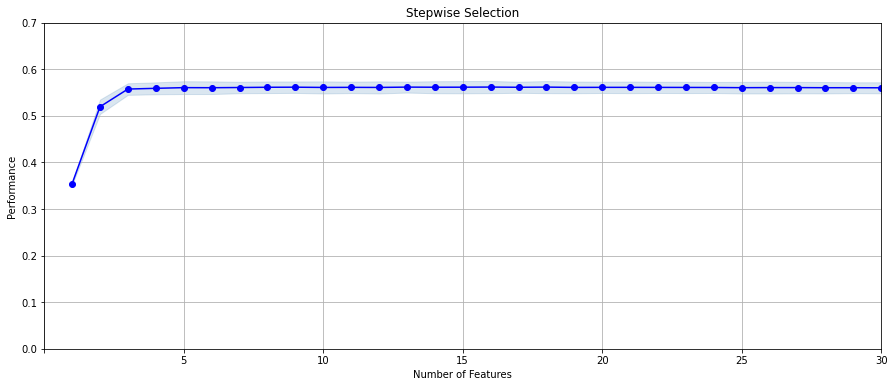

In [81]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [82]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS.head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 55)","[0.5040919380114922, 0.5349120668640084]",0.519502,"(fulladdress_count_30, ssn_count_30)",0.066304,0.01541,0.01541
3,"(3, 55, 81)","[0.5450113181264148, 0.5699111962388995]",0.557461,"(fulladdress_count_30, ssn_count_30, homephone...",0.053568,0.01245,0.01245
4,"(3, 10, 55, 81)","[0.5462301932787742, 0.5718265714783214]",0.559028,"(fulladdress_count_30, fulladdress_unique_coun...",0.055066,0.012798,0.012798
5,"(3, 10, 25, 55, 81)","[0.546752568344071, 0.5742643217830402]",0.560508,"(fulladdress_count_30, fulladdress_unique_coun...",0.059187,0.013756,0.013756


In [83]:
vars_FS.head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 55)","[0.5040919380114922, 0.5349120668640084]",0.519502,"(fulladdress_count_30, ssn_count_30)",0.066304,0.01541,0.01541
3,"(3, 55, 81)","[0.5450113181264148, 0.5699111962388995]",0.557461,"(fulladdress_count_30, ssn_count_30, homephone...",0.053568,0.01245,0.01245
4,"(3, 10, 55, 81)","[0.5462301932787742, 0.5718265714783214]",0.559028,"(fulladdress_count_30, fulladdress_unique_coun...",0.055066,0.012798,0.012798
5,"(3, 10, 25, 55, 81)","[0.546752568344071, 0.5742643217830402]",0.560508,"(fulladdress_count_30, fulladdress_unique_coun...",0.059187,0.013756,0.013756


In [84]:
vars_FS['Previous Features'] = vars_FS.feature_names.shift().fillna('')
vars_FS['New Feature'] = vars_FS.apply(lambda x : list(set(x['feature_names']) - set(x['Previous Features']))[0], axis = 1) 

In [85]:
vars_FS['New Feature'] = vars_FS.apply(lambda x : list(set(x['feature_names']) - set(x['Previous Features']))[0], axis = 1) 

In [86]:
vars_final = [i for i in vars_FS['New Feature']]

In [20]:
# vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
# vars_final

['address_count_30',
 'fulladdress_count_30',
 'address_count_14',
 'address_count_7',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_zip5_60',
 'fulladdress_unique_count_for_ssn_fulladdress_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_fulladdress_dob_60',
 'fulladdress_unique_count_for_ssn_name_30',
 'fulladdress_unique_count_for_ssn_lastname_30',
 'fulladdress_unique_count_for_ssn_zip5_30',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'fulladdress_unique_count_for_ssn_fulladdress_14',
 'fulladdress_unique_count_for_fulladdress_dob_14',
 'fulladdress_unique_count_for_ssn_fulladdress_7',
 'fulladdress_unique_count_for_ssn_7',
 'fulladdress_unique_count_for_ssn_lastname_7',
 'fulladdress_unique_count_for_ssn_name_dob_7',
 'fulladdress_unique_count_for_fulladdress_dob_7',
 'fulladdress_unique_count_for_name_dob_7',

In [36]:
vars_FS.to_csv('VarsFS.csv', index=False)

In [87]:
vars_FS.filter(['New Feature','avg_score']).merge(filter_score, right_on = 'variable',left_on = 'New Feature').to_csv("VarsFS2.csv")

In [46]:
sfs.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.35173254, 0.35678217]),
  'avg_score': 0.35425735678216963,
  'feature_names': ('fulladdress_count_30',)},
 2: {'feature_idx': (3, 78),
  'cv_scores': array([0.50356956, 0.53543444]),
  'avg_score': 0.5195020024377504,
  'feature_names': ('fulladdress_count_30', 'ssn_dob_count_30')},
 3: {'feature_idx': (3, 10, 78),
  'cv_scores': array([0.50722619, 0.53613094]),
  'avg_score': 0.5216785652098207,
  'feature_names': ('fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 4: {'feature_idx': (2, 3, 10, 78),
  'cv_scores': array([0.50722619, 0.54065819]),
  'avg_score': 0.5239421904927739,
  'feature_names': ('address_count_30',
   'fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 5: {'feature_idx': (2, 3, 10, 73, 78),
  'cv_scores': array([0.50809681, 0.54118057]),
  'avg_score': 0.5246386905798364,
  'feature_names': ('address_count_30',
  

In [47]:
vars_final.append('index_name')
vars_final.append('y_name')
vars_final

['fulladdress_count_30',
 'ssn_dob_count_30',
 'fulladdress_unique_count_for_dob_homephone_60',
 'address_count_30',
 'fulladdress_count_0_by_3',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_ssn_name_dob_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_ssn_name_dob_30',
 'fulladdress_unique_count_for_fulladdress_dob_60',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'ssn_name_dob_count_30',
 'name_dob_count_14',
 'name_dob_count_30',
 'fulladdress_unique_count_for_name_dob_7',
 'fulladdress_unique_count_for_dob_homephone_7',
 'fulladdress_unique_count_for_ssn_fulladdress_7',
 'fulladdress_unique_count_for_fulladdress_dob_7',
 'fulladdress_unique_count_for_ssn_name_30',
 'fulladdress_unique_count_for_ssn_name_7',
 'fulladdress_unique_count_for_ssn_7',
 'ssn_count_30',
 'fulladdress_unique_count_for_ssn_zip5_60',
 'fulladdress_unique_count_for_ssn_name_60',
 'fulladdress_count_3',
 'fulladdress_unique_count_for_ssn_las

In [56]:
X_final = df_keep.filter(vars_final, axis=1)
X_final.shape

(794997, 30)

In [57]:
X_final.to_csv('vars_final.csv', index=False)

In [58]:
# print('time to here:', dt.datetime.now() - start_time)